<a href="https://colab.research.google.com/github/Jackil1993/autologistics/blob/main/SKU_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
df = pd.read_parquet('/content/gdrive/My Drive/Data/ML/sku_small.gzip')

In [ ]:
df

,Unit price,Number of units,Gross weight,Height
0,0.058,1920,105.60,1.56
1,0.954,384,207.68,1.00
2,2.385,108,165.78,1.02
3,5.100,72,221.04,1.05
4,1.110,384,207.68,1.00
...,...,...,...,...
1205,4.813,48,110.40,0.64
1206,15.960,80,300.00,1.19
1207,1.470,192,76.80,1.19
1208,1.780,840,319.20,1.19


The dataset contains SKU data at the pallet level. There are four features in total: 
<br> 1) unit price <br>2) number of units per pallet <br>3) pallet gross weight <br>4) pallet height

In [ ]:
df.describe()

,Unit price,Number of units,Gross weight,Height
count,1210.000000,1210.000000,1210.000000,1210.000000
mean,4.750660,349.570248,244.051481,1.041670
std,5.072757,553.945664,118.471325,0.251354
min,0.011000,12.000000,10.160000,0.360000
25%,1.131750,72.000000,165.780000,0.900000
50%,2.705500,108.000000,226.800000,1.020000
75%,5.555750,384.000000,293.760000,1.050000
max,19.760000,2400.000000,777.600000,1.800000


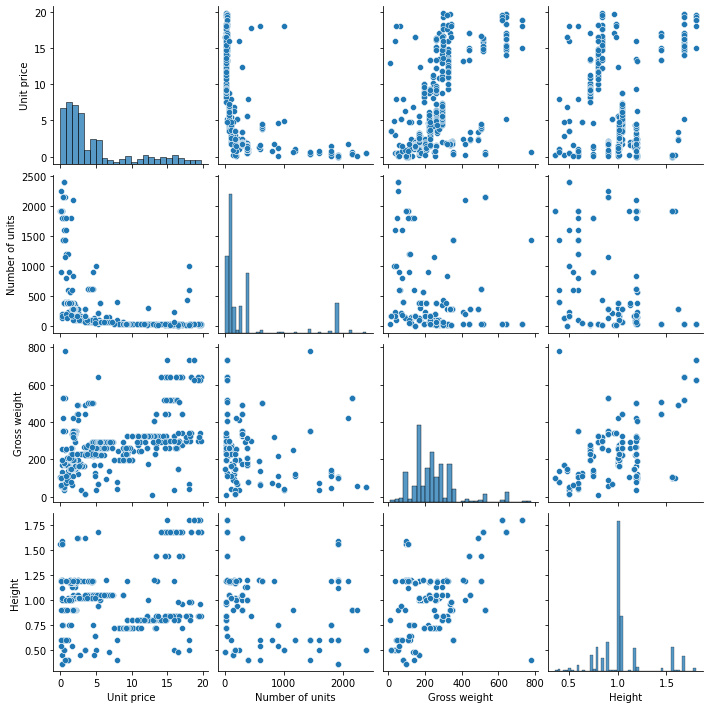

In [ ]:
sns.pairplot(df)
fig = plt.gcf()
fig.savefig('pairplot.png')

In [ ]:
corr = df.corr()
corr

,Unit price,Number of units,Gross weight,Height
Unit price,1.000000,-0.431449,0.607135,0.029654
Number of units,-0.431449,1.000000,-0.297613,0.291412
Gross weight,0.607135,-0.297613,1.000000,0.240931
Height,0.029654,0.291412,0.240931,1.000000


In [ ]:
cols  = list(df.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df)
scaled_df = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)

In [ ]:
scaled_df

,Unit price,Number of units,Gross weight,Height
0,0.002380,0.798995,0.124362,0.833333
1,0.047749,0.155779,0.257375,0.444444
2,0.120209,0.040201,0.202778,0.458333
3,0.257684,0.025126,0.274784,0.479167
4,0.055648,0.155779,0.257375,0.444444
...,...,...,...,...
1205,0.243152,0.015075,0.130616,0.194444
1206,0.807585,0.028476,0.377671,0.576389
1207,0.073877,0.075377,0.086834,0.576389
1208,0.089574,0.346734,0.402689,0.576389


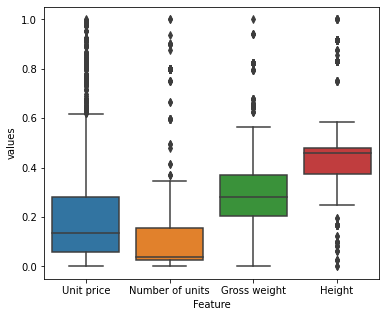

In [ ]:
dfs = []
for i in cols:
  tmp = pd.DataFrame(scaled_df[i])
  tmp.rename(columns={i: 'values'}, inplace=True)
  tmp['Feature'] = i
  dfs.append(tmp)

data= pd.concat(dfs)
sns.boxplot(x="Feature", y="values", data=data)
fig = plt.gcf()
fig.set_size_inches(6, 5)
fig.savefig('1.png')

In [ ]:
data.reset_index(inplace=True)

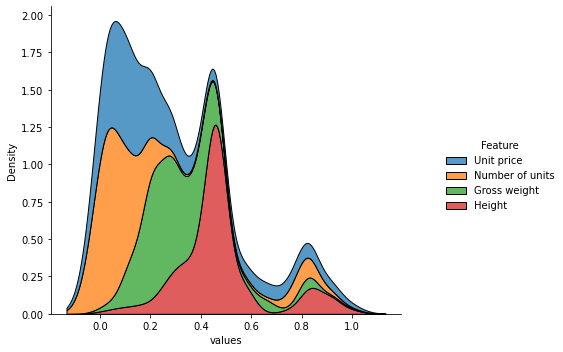

In [ ]:
#sns.displot(data, x="values", hue="Feature", kind="kde", fill=True)
sns.displot(data, x="values", hue="Feature", kind="kde", multiple="stack")
fig = plt.gcf()
fig.set_size_inches(8, 5)
fig.savefig('2.png')

In [ ]:
def cluster(data, npc=0, k=2):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler.fit(data)
  scaled = scaler.transform(data)
  if  npc != 0:
    pca = PCA(n_components=npc)
    pca.fit(scaled)
    #print('Variance preserved after PCA: ', pca.explained_variance_ratio_.sum())
    scaled = pca.transform(scaled)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled)
  sc = silhouette_score(scaled, kmeans.labels_)
  return sc, kmeans.labels_
  # kmeans.labels_, kmeans.cluster_centers_
def automagic():
  n_pcs = [0, 2, 3]
  ks = [i for i in range(2, 10)]
  scores = []
  n_PC = []
  Ks = []
  for i in n_pcs:
    for j in ks:
      score, _ = cluster(df, npc=i, k=j)
      scores.append(score)
      n_PC.append(i)
      Ks.append(j)
  table = pd.DataFrame()
  table['Ks'] = Ks
  table['PCs'] = n_PC
  table['Score'] = scores
  table['PCs'] = table['PCs'].replace(0, 'No')
  sns.lineplot(data=table, x='Ks', y='Score', hue='PCs', palette=sns.color_palette(n_colors=3))
  plt.grid()
  fig = plt.gcf()
  fig.set_size_inches(8, 5)
  fig.savefig('results.png')
  return table

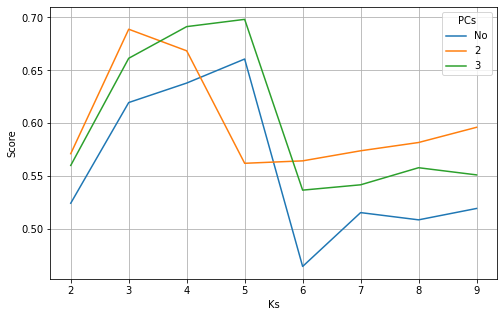

In [ ]:
results = automagic()

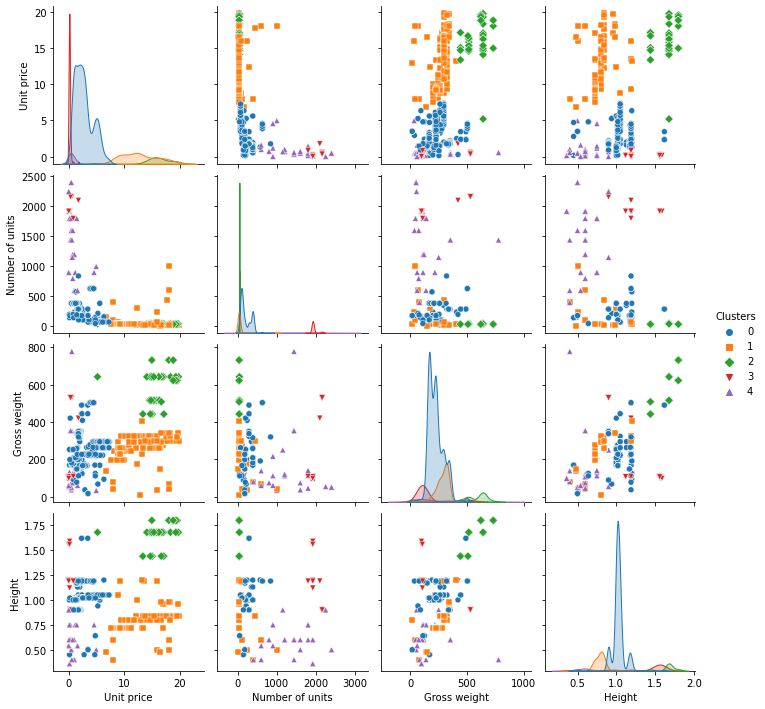

In [ ]:
_, labels = cluster(df, npc=3, k=5)
df['Clusters'] = labels #labels
sns.pairplot(df, hue='Clusters', palette=sns.color_palette(n_colors=5), markers=["o", "s", 
                                                                                 "D", "v", "^"])
#sns.pairplot(df, diag_kind="hist", hue='Clusters', palette=sns.color_palette(n_colors=5))
fig = plt.gcf()
fig.savefig('final_clustering.png')

In [ ]:
results

,Ks,PCs,Score
0,2,No,0.524462
1,3,No,0.619557
2,4,No,0.637970
3,5,No,0.660665
4,6,No,0.464723
5,7,No,0.515586
6,8,No,0.508747
7,9,No,0.519497
8,2,2,0.571250
9,3,2,0.688815


In [ ]:
scaled_df['Clusters'] = df['Clusters']

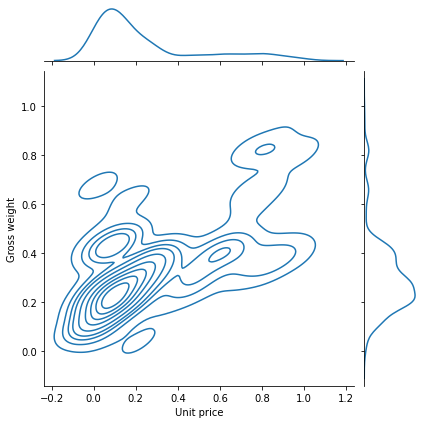

In [ ]:
sns.jointplot(
    data=scaled_df,
    x="Unit price", y="Gross weight", palette=sns.color_palette(n_colors=5),
    kind="kde"
)
fig = plt.gcf()
fig.savefig('jointplot.png', dpi=500)

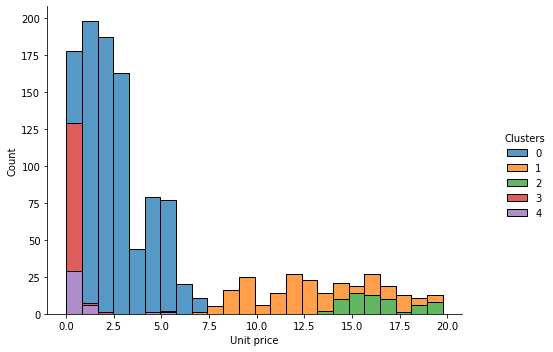

In [ ]:
sns.displot(df, x="Unit price", hue="Clusters", multiple="stack", palette=sns.color_palette(n_colors=5))
fig = plt.gcf()
fig.set_size_inches(8, 5)